In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt 
import torch
import torchvision
from torchvision import datasets, transforms

In [2]:
files = glob.glob("new_init*_final_data.npy")

In [3]:
def parser(file):
    """
    return phi, disc learning rate
    """
    i0 = file.index("lrD_")+len("lrD_")
    i1 = file.index("_lrQ_")
    i2 = file.index("_phi_")+len("_phi_")
    i3 = file.index("_final_data.npy")
    
    return float(file[i2:i3]), float(file[i0:i1])

In [4]:
train_loader = torch.utils.data.DataLoader(datasets.MNIST('../mnist_data', 
                                                          download=True, 
                                                          train=True,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ])), 
                                           batch_size=100, 
                                           shuffle=False)



for data, label in train_loader:
    data = data.reshape((-1, 784)).type(torch.DoubleTensor).numpy()
    break

To evaluate mode collapse, lets evaluate the distance between the learned data, and the dataset

In [5]:
def eval_mnist(array):
    array = np.reshape(array, (-1, 784))
    
    norms = np.sqrt(np.sum(array**2, -1))[..., None]
    
    normed_array = array/norms
    
    data_norms = np.sqrt(np.sum(data**2, -1))[..., None]
    
    normed_data = data/data_norms
    
    cosdistances = 1 - np.sum(normed_data[:, None, :] * normed_array[None, :, :], -1)
    
    """
    Now we have a list of distances 
    
    we want to know a couple things:
    the distribution of closest q points
    
    the average minimum distance
    
    go through each particle, identify closest datapoint
    """
    closest_datapoints = np.argmin(cosdistances, 0)
    
    """
    now we want to count the distribution here
    """
    probs = np.zeros(normed_array.shape[0])
    
    for index in closest_datapoints:
        probs[index]+=1
    
    probs = probs/(np.sum(probs))
    
    
    #now we compute the entropy 
    diversity = np.log(100)+np.sum(probs*np.log(probs + 10**-8))
    
    """
    now we compute the average min dist
    """
    mean_mindist = np.mean(np.min(cosdistances, 0))
    
    return mean_mindist, diversity

In [6]:
np.log(100)

4.605170185988092

In [7]:
eval_mnist(data)

(-2.2315482794965644e-16, 9.999995000953277e-07)

In [8]:
def evaluate_diversity(array):
    if len(array.shape)==3:
        array = np.reshape(array, (-1, 784))
    
    norms = np.sqrt(np.sum(array**2, -1))[..., None]
    
    normed_array = array/norms
    
    dots = np.abs(np.sum((normed_array[None, :, :]*normed_array[:, None, :]), -1))
    
    mean_dot = (np.sum(dots) - array.shape[0])/(array.shape[0] * (array.shape[0] - 1))
    
    return mean_dot

In [9]:
# A test of this

evaluate_diversity(array = np.ones((10, 100)))

1.0000000000000002

In [10]:
phis = []
lrds = []
mindists = []
divs = []

In [11]:
for file in files:
    
    phi, lrd = parser(file)
    
    if lrd<.5*10**-4:
        continue
    mean_mindist, diversity = eval_mnist(np.load(file))
    
    mindists.append(mean_mindist)
    divs.append(diversity)
    
    phis.append(phi)
    lrds.append(lrd)

In [12]:
plt.style.use('default')

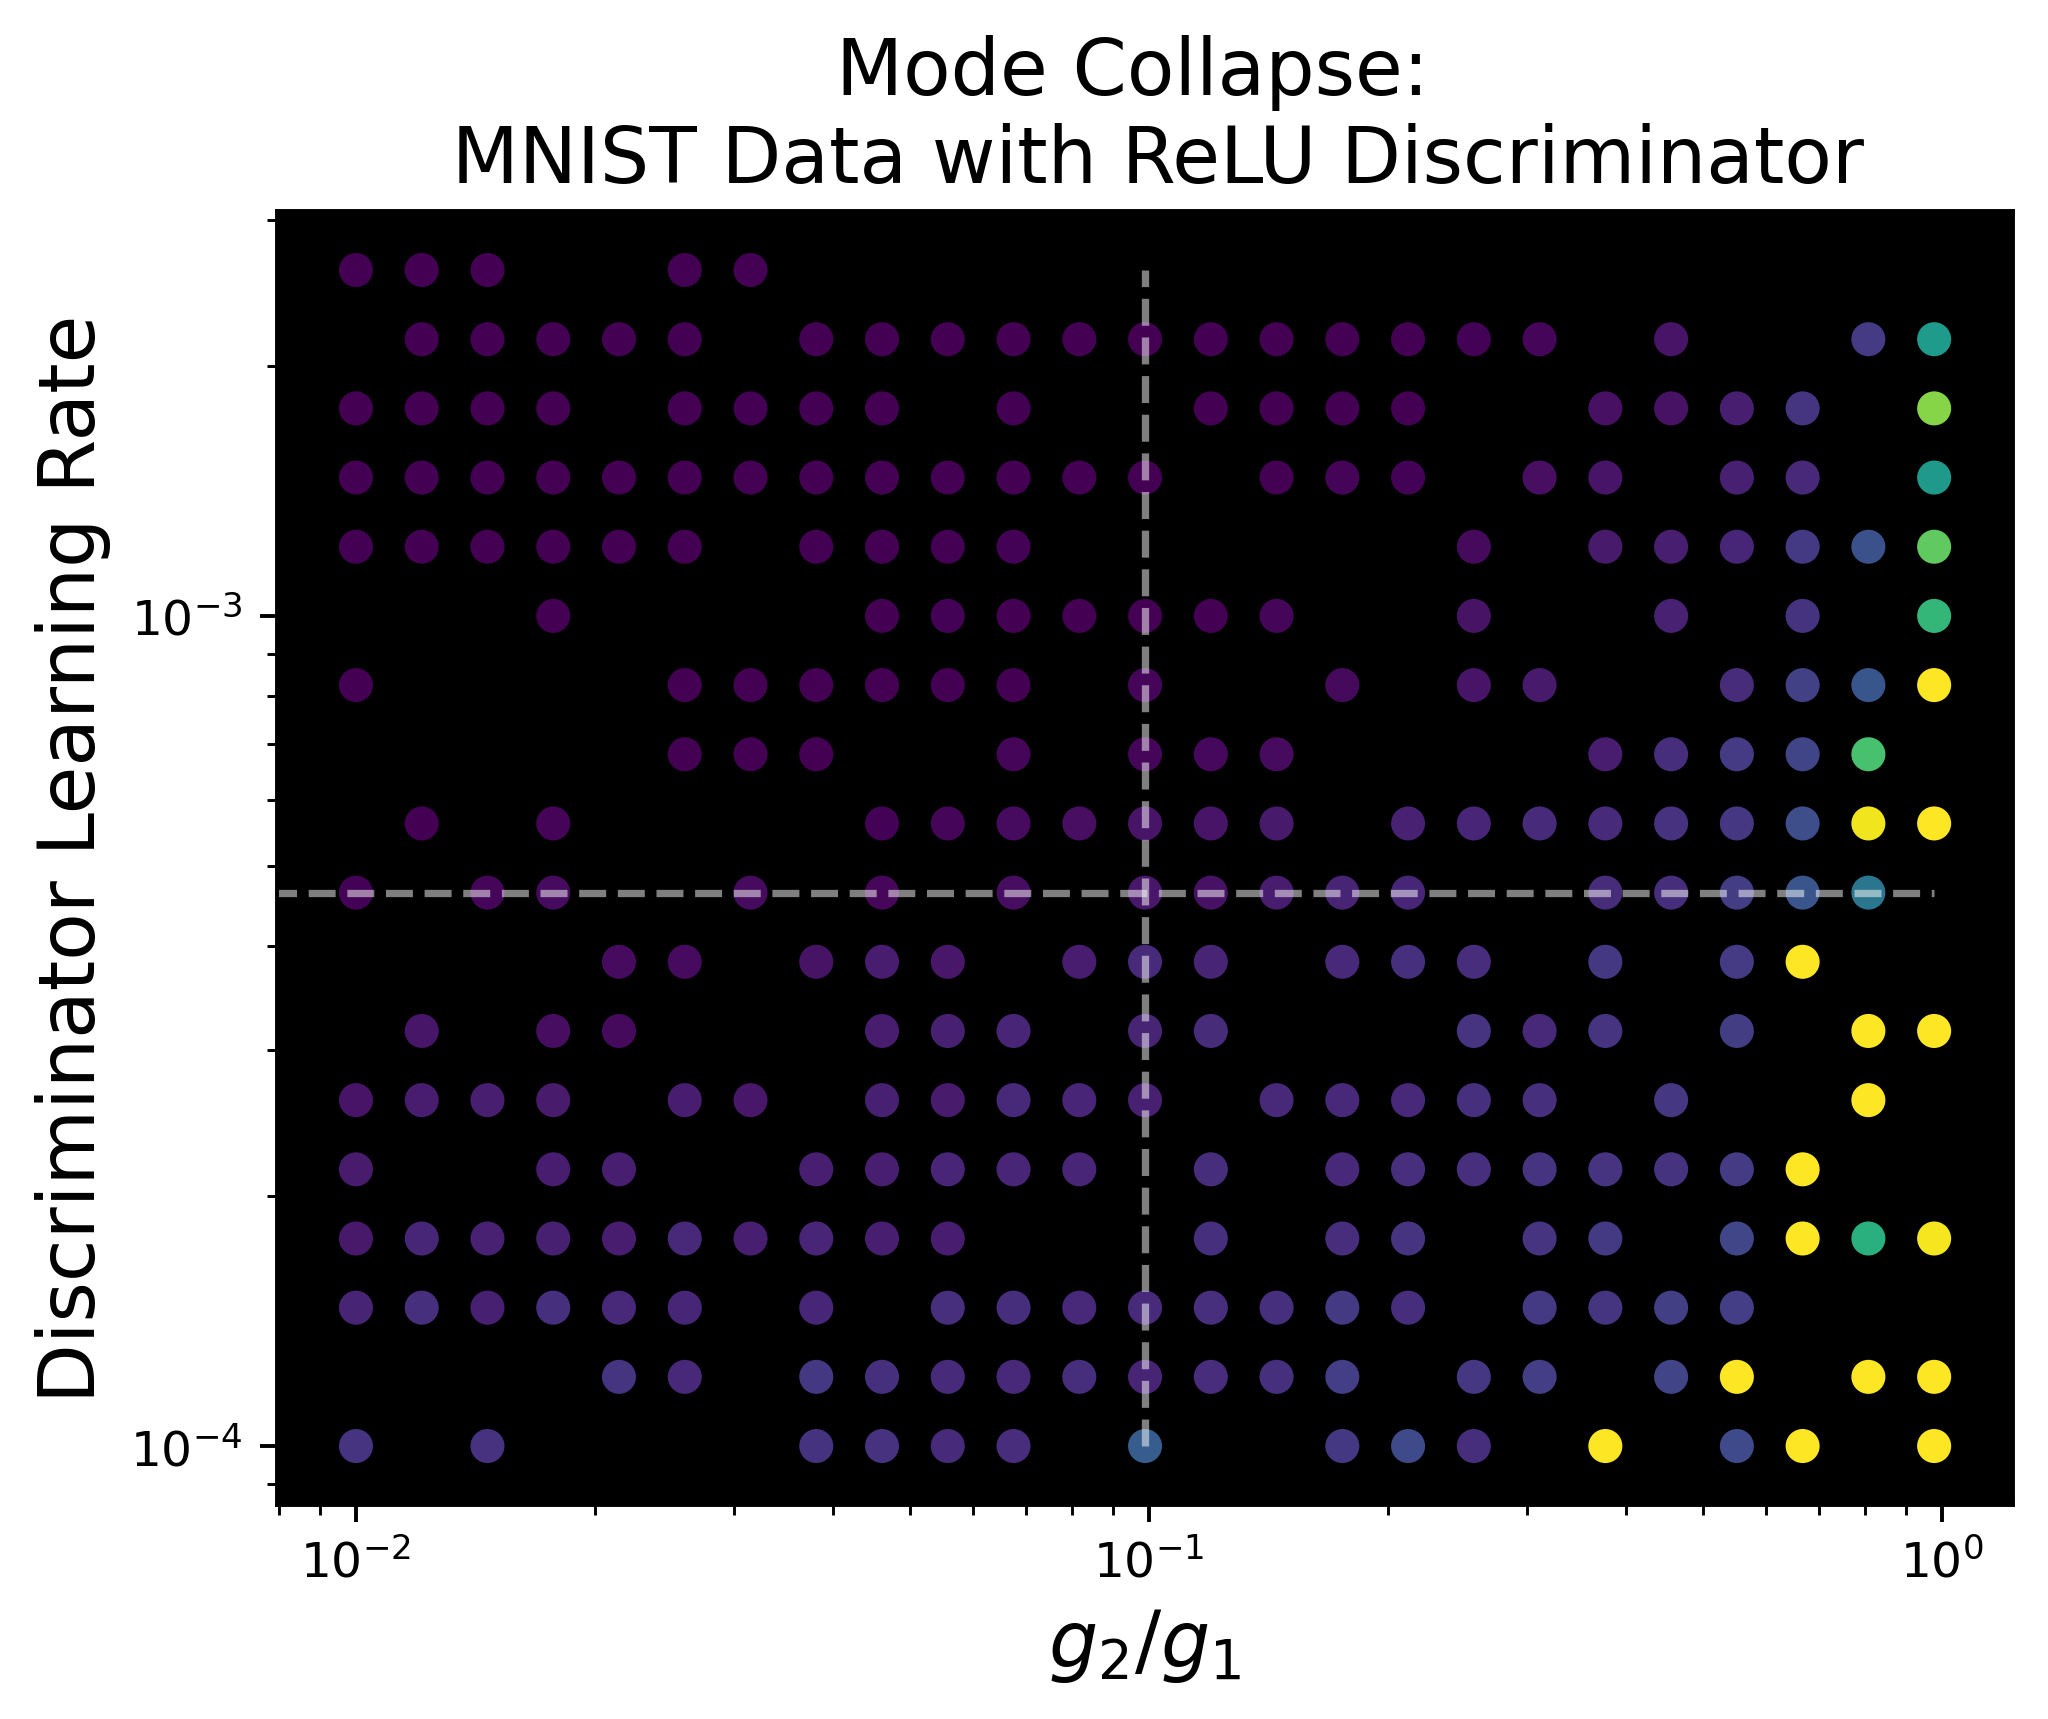

In [13]:
f, a = plt.subplots(dpi=350)

a.scatter(phis, lrds, c=divs)
a.set_title("Mode Collapse: \n MNIST Data with ReLU Discriminator", fontsize=16)
a.set_ylabel(r"Discriminator Learning Rate", fontsize=16)
a.set_xlabel(r"$g_2 / g_1$", fontsize=16)
a.set_yscale("log")
a.set_xscale("log")

a.set_facecolor("black")

a.hlines(0.00046415888336127773, min(phis), max(phis), alpha=.5, linestyle='dashed', color='white')

a.vlines(0.0988553094656939, min(lrds), max(lrds), alpha=.5, linestyle='dashed', color='white')

f.savefig("MNIST_mode_collapse_diagram.pdf")

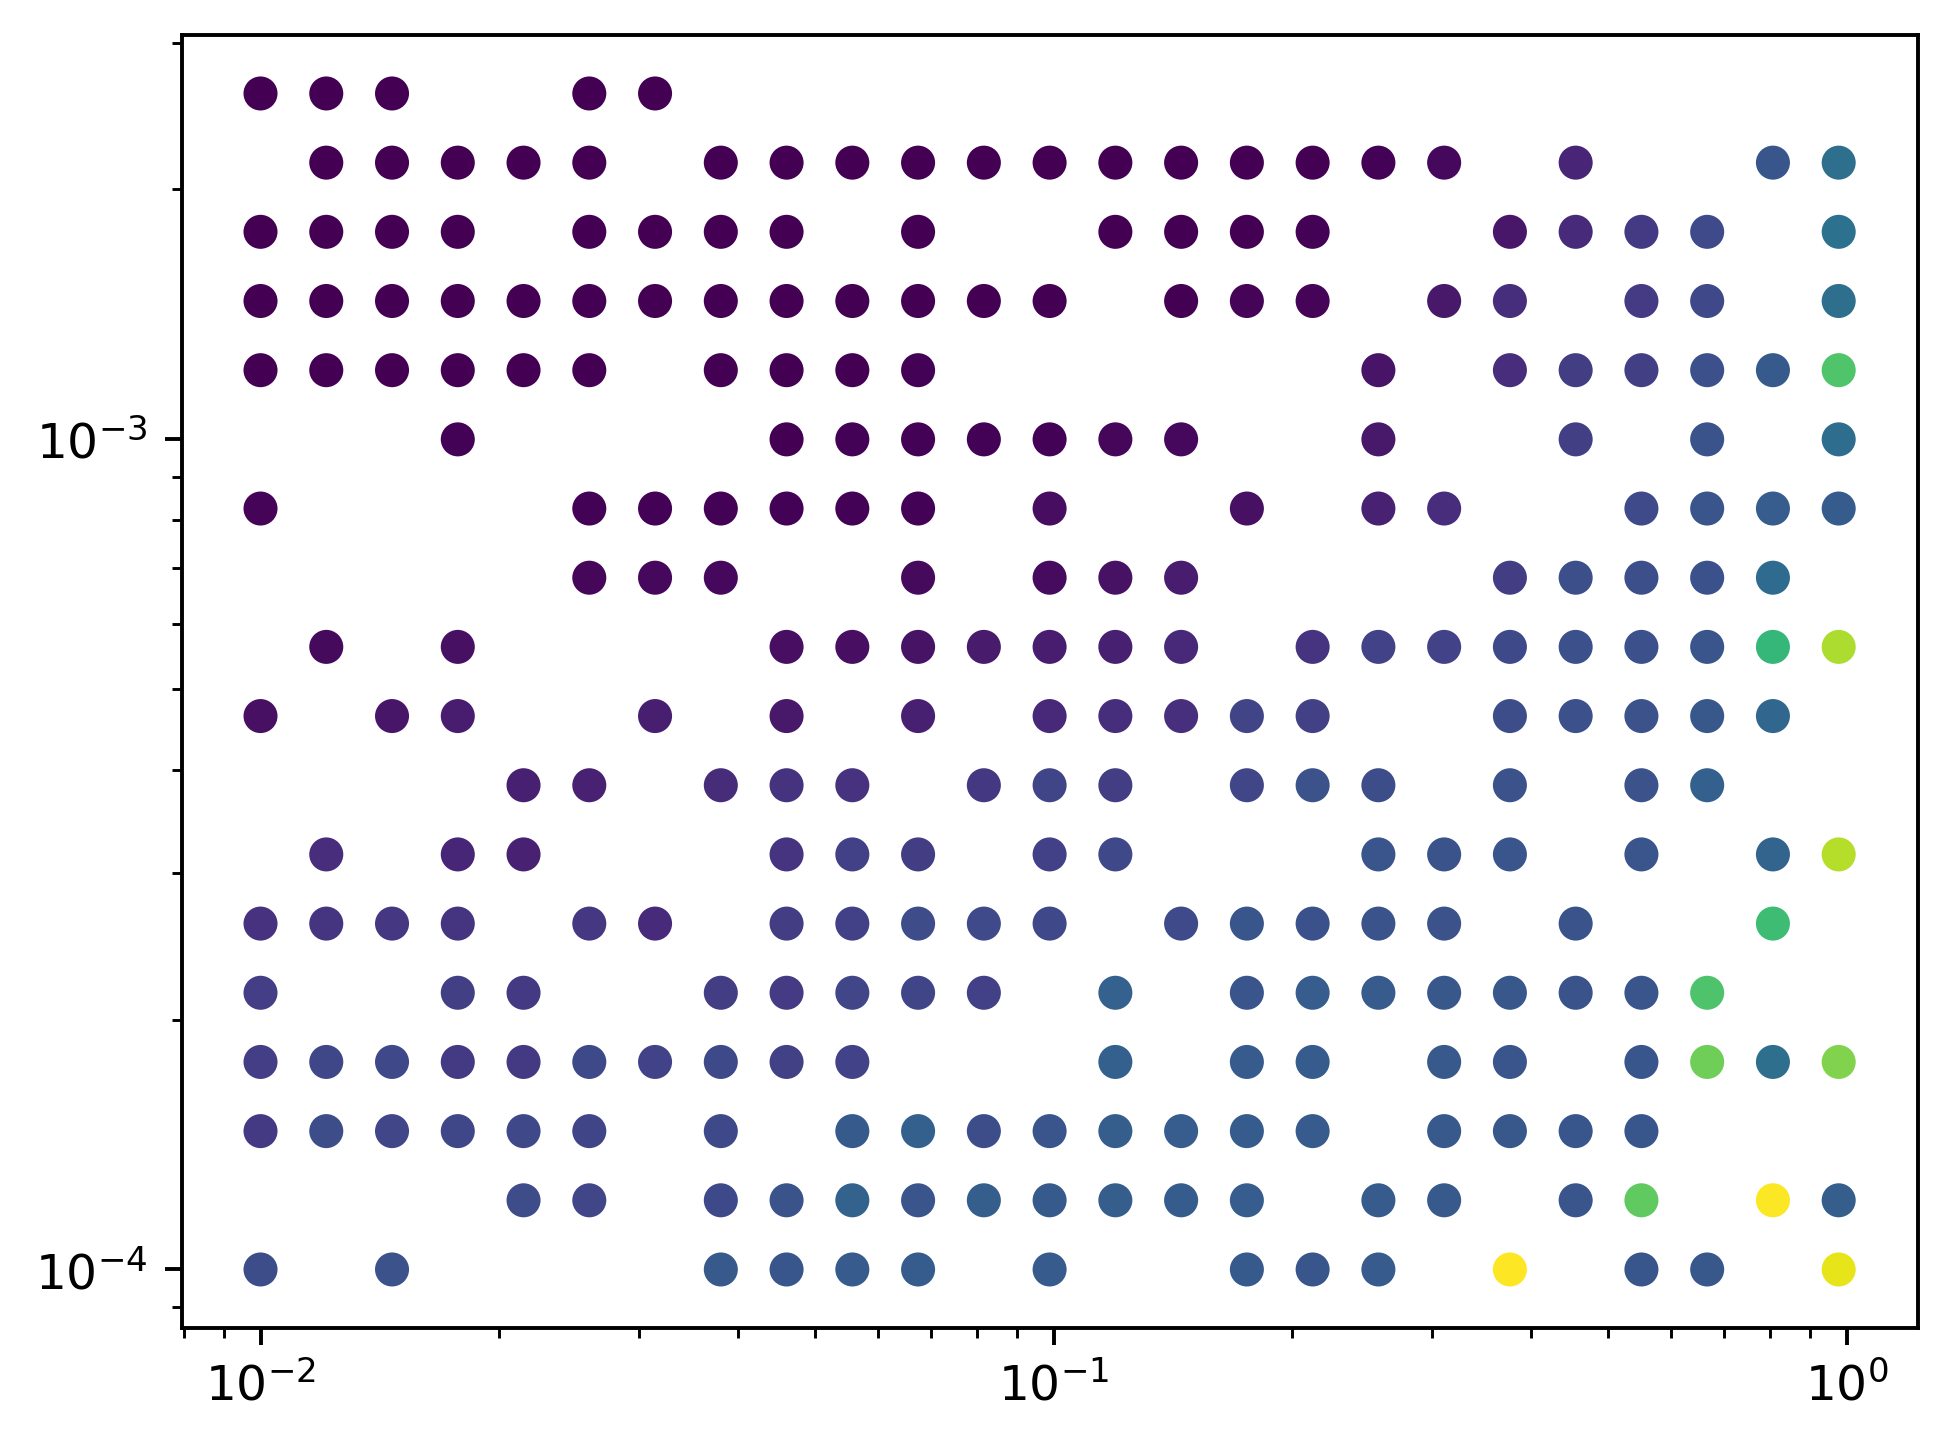

In [14]:
f, a = plt.subplots(dpi=350)

a.scatter(phis, lrds, c=mindists)
a.set_yscale("log")
a.set_xscale("log")

# Plot Slices

In [15]:
plt.style.use('default')

C:\Users\durrc\AppData\Local\Temp\ipykernel_10276\1914988653.py:41: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  f.tight_layout()


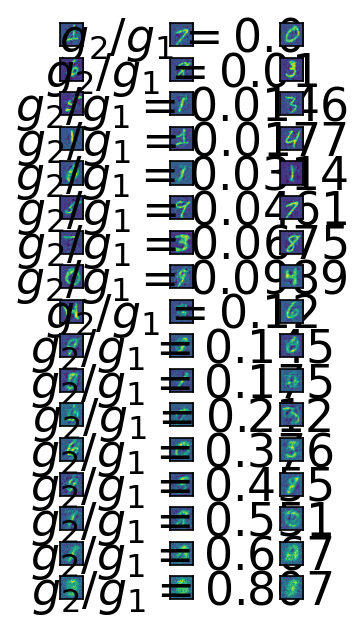

In [16]:

fixed_lrd_files = []

for file in files:
    
    phi, lrd = parser(file)
    
    if 0.00046415888336127773 == lrd:
        fixed_lrd_files.append(file)
        
    

fixed_lrd_files.sort(key = lambda file: parser(file)[0])

tokeep = range(len(fixed_lrd_files))

n=3
f, a = plt.subplots(len(tokeep), n, dpi=150)
count=0

for index, file in enumerate(fixed_lrd_files):
    
    if index not in tokeep:
        continue
    
    for i in range(n):
        interval=7
        #some interval of images to sample from
        
        a[count, i].imshow(np.load(file)[i*interval, ...].reshape((28,28)))
        a[count, i].set_xticks([], [])
        a[count, i].set_yticks([], [])
    a[count, 1].set_xlabel(r"$g_2 / g_1 = $"+f"{'%s' % float('%.3g' % parser(file)[0])}", fontsize=22)
    a[count, 1].xaxis.set_label_coords(.5, 1.4)
    count+=1
f.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=-.8,
                    hspace=0.5)
f.tight_layout()

plt.show()



In [17]:
## plot g2/g1 slices

In [18]:
phis

[0.021461825858012776,
 0.025976661391943993,
 0.03805543290345671,
 0.0460609969159666,
 0.05575065831664657,
 0.06747869370717137,
 0.08167390739252774,
 0.0988553094656939,
 0.11965109202614409,
 0.1448215973469495,
 0.17528711776018926,
 0.25679309007861667,
 0.3108135902739475,
 0.4553374104426248,
 0.5511248580808259,
 0.8073899390560751,
 0.9772372209558107,
 0.0,
 0.012103658637340777,
 0.01464985524092739,
 0.017731684692264285,
 0.01,
 0.021461825858012776,
 0.025976661391943993,
 0.03805543290345671,
 0.05575065831664657,
 0.06747869370717137,
 0.08167390739252774,
 0.0988553094656939,
 0.11965109202614409,
 0.1448215973469495,
 0.17528711776018926,
 0.21216154368926846,
 0.3108135902739475,
 0.3761981596522162,
 0.4553374104426248,
 0.5511248580808259,
 0.0,
 0.012103658637340777,
 0.01464985524092739,
 0.017731684692264285,
 0.01,
 0.021461825858012776,
 0.025976661391943993,
 0.03144126420258796,
 0.03805543290345671,
 0.0460609969159666,
 0.05575065831664657,
 0.11965109

C:\Users\durrc\AppData\Local\Temp\ipykernel_10276\2523004911.py:43: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  f.tight_layout()


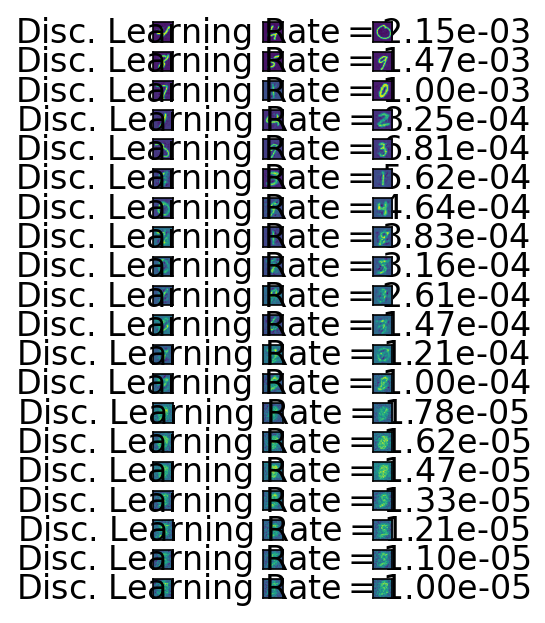

In [19]:

fixed_phi_files = []

for file in files:
    
    phi, lrd = parser(file)
    
    if 0.0988553094656939 == phi:
        fixed_phi_files.append(file)
    
fixed_phi_files.sort(key = lambda file: -parser(file)[1])

tokeep = range(len(fixed_phi_files))

n=3
f, a = plt.subplots(len(tokeep), n, dpi=150)
count=0

for index, file in enumerate(fixed_phi_files):
    
    if index not in tokeep:
        continue
    
    for i in range(n):
        interval=7
        #some interval of images to sample from
        
        a[count, i].imshow(np.load(file)[i*interval, ...].reshape((28,28)))
        a[count, i].set_xticks([], [])
        a[count, i].set_yticks([], [])
    
    a[count, 1].set_xlabel(r"Disc. Learning Rate$=$"+'{:.2e}'.format(float(parser(file)[1])), fontsize=16)
    
    a[count, 1].xaxis.set_label_coords(.5, 1.4)
    count+=1
    

f.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=-.8,
                    hspace=0.5)
f.tight_layout()

plt.show()

